In [1]:
"""
plot the time series of media storms identified from April 1, 2020 - December 1, 2021
"""

'\nplot the time series of media storms \n'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"

stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

artDf = artDf.drop(columns=["Unnamed: 0"])
stormsDf = stormsDf.drop(columns=["Unnamed: 0"])

SCOL = "20000_90"
stormsDf[SCOL + "_storm"] = True

merged = pd.merge(artDf, stormsDf.drop(columns=[SCOL]), on="key", how="left")

#important: remove any dates before our first local date 
merged = merged[merged["date"] >= "2020-04-01"]


<ipython-input-3-d15d318dab54>:5: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [13]:
#shouldn't have filtered on string up above but it did the job 
merged["date"] = pd.to_datetime(merged["date"])

In [14]:
#get each date as a date since the first story in our data 
#get the first date in our dataset 
minDate = min(merged["date"])

merged["dateInt"] = merged["date"].apply(lambda x: (x - minDate) / np.timedelta64(1, "D"))

In [18]:
SCOL = "20000_90"

In [20]:
#get largest stories 
sClustDf = merged[["source", SCOL, "national", "key", "content", "title", "date", "dateInt", "state", "lat", "lon"]].groupby(SCOL).agg(list).reset_index()
sClustDf["clustSize"] = sClustDf["key"].apply(len)
sClustDf["nationalPercent"] = sClustDf["national"].apply(np.mean)
sClustDf["duration"] = ((sClustDf["date"].apply(max) - sClustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
#get the number of unique states in this story 
sClustDf["numStates"] = sClustDf["state"].apply(getUnique)

In [388]:
#get largest stories 
clustDf = df[["source", "clustNum", "national", "key", "content", "title", "date", "dateInt", "state", "lat", "lon"]].groupby("clustNum").agg(list).reset_index()
clustDf["clustSize"] = clustDf["key"].apply(len)
clustDf["nationalPercent"] = clustDf["national"].apply(np.mean)
clustDf["duration"] = ((clustDf["date"].apply(max) - clustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
#get the number of unique states in this story 
clustDf["numStates"] = clustDf["state"].apply(getUnique)

In [390]:
#get variance of our date integer 
clustDf["dateStd"] = clustDf["dateInt"].apply(np.std) 

In [108]:
#consideration: maybe make a cutoff using the variance of news story duration? 

In [ ]:
#political unrest in Belarus 
#nashville bombing 
#couple pointing guns at protestors 

In [33]:
#get the top stories in long format so we can plot their times series 
def generateTopStories(clustDf, topStoryNum, sortCol): 
    
    #typically sortCol will be "clustSize", but can also be spike size or something else 
    #get top number of stories for this column 
    topStories = clustDf.sort_values(sortCol, ascending=False).head(topStoryNum)

    #return the date ints that has the highest frequency in the inList of date ints 
    def maxDateInt(inList): 
        return Counter(inList).most_common()[0][0]

    #this will be used to sort stories by their peaks 
    topStories["topDay"] = topStories["dateInt"].apply(maxDateInt)

    def getUnique(inList): 
        return len(set([item for item in inList if item == item]))
    
    #explode stories out from the story level, then group back again at the story,day level 
    topStories = topStories.explode(["source", "national", "key", "content", "title", "date", "dateInt", "lat", "lon", "state"])
    topStoriesDaily = topStories[[SCOL, "dateInt", "key", "topDay", "lat", "lon", "state"]].groupby([SCOL, "dateInt"])\
    .agg({"key":len, "topDay":list, "state":getUnique, "lat":list, "lon":list}).reset_index()

    topStoriesDaily["topDay"] = topStoriesDaily["topDay"].apply(lambda x: x[0])
    
    return topStoriesDaily 


In [88]:
def plotTopStories(topStoriesDaily,  savePath): 
    outTups = []
    fig, ax = plt.subplots(figsize=(12, 3.5))
    palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
    for i, clustNum in enumerate(topStoriesDaily.sort_values("topDay", ascending=True)[SCOL].unique()): 
        currColor = palette[i % len(palette)]
        currStories = topStoriesDaily[topStoriesDaily[SCOL] == clustNum] #.drop(columns=["key"])

        #get the day ints that we need to fill in
        lastDay = max(merged["dateInt"])
        missingDays = set(range(0, int(lastDay))) - set(currStories["dateInt"].unique())

        #a dataframe to fill in missing days with 0 stories 
        topDay = list(currStories["topDay"])[0]
        missingDaysDf = pd.DataFrame({SCOL:clustNum, "dateInt":list(missingDays), "key":0, "topDay":topDay})
        currStories = pd.concat([currStories, missingDaysDf], axis=0).sort_values("dateInt")

        ax.plot(currStories["dateInt"], currStories["key"], color=currColor)
        #seaborn version: (same) plot = sns.lineplot(x="dateInt",y="key",data=currStories, alpha=1)
        ax.fill_between(currStories.dateInt.values, currStories.key.values, zorder=i, color=currColor)
        outTups.append((clustNum, currColor, topDay))
        
    ax.set_title(f"Media Storms: April 1, 2020 - December 31, 2021")
    ax.set_xlabel("day since April 1")
    ax.set_ylabel("# of articles")
    ax.set_xlim(0, lastDay)
    plt.savefig(savePath, bbox_inches="tight")
    plt.show()
    return outTups

In [89]:
FIG_PATH = "/home/blitt/projects/localNews/reports/figures/drafts/"
PALETTE = ["#008837", "#7b3294"]

In [90]:
numStorms = len(stormsDf[SCOL].unique())
numStorms

98

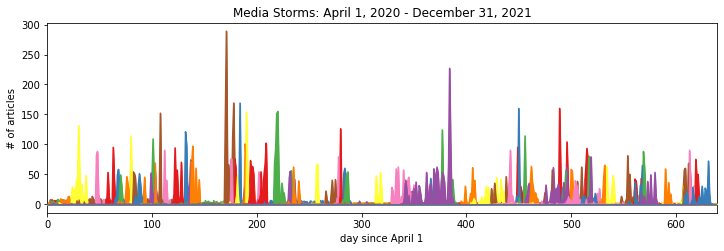

In [91]:
#first, look at all storms 
topStoriesDaily = generateTopStories(sClustDf, numStorms, "clustSize")
outTups = plotTopStories(topStoriesDaily, savePath = FIG_PATH + "allStormsSeries.pdf")